<a href="https://colab.research.google.com/github/Bharathi-A-7/Bharathi/blob/master/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dataset**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('/content/drive/My Drive/Online Retail.csv',encoding='unicode_escape')
data.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# **Data Preprocessing**

In [0]:
print(f'Duplicate Items in Dataset:{data.duplicated().sum()}')

Duplicate Items in Dataset:5268


# **Remove Duplicate items from dataset**

In [0]:
data = data[~data.duplicated()]

# **Check for missing values**

In [0]:
print(f'Count of Missing values:{data.isnull().sum()}')

Count of Missing values:InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


# **Create new Invoice List**

In [0]:
#Creates a list of unique invoice No. with Null Customer ID

invoice_list = data[data.CustomerID.isnull()]['InvoiceNo'].tolist()
print(invoice_list)

['536414', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544', '536544',

In [0]:
len(data[data.InvoiceNo.isin(invoice_list)])

135037

# **Create Train Data**

# Removing Inconsistent Records

In [0]:
print("The number of records with Quantity Negative and Prices 0 or Vice versa : ",data[(data.Quantity<=0) & (data.UnitPrice<=0)].shape[0])

#Checking if Negative quantities are cancelled items 
print("Cancelled Items have Invoice Starting with : ",data.loc[(data.Quantity<0) & ~(data.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

#Checking for Records with Negative Unit Price
print("The number of transactions with Negative Unit Price : ",data[(data.UnitPrice<0)].shape[0])

#Checking for Records with Unit Price 0
print("The number of transactions with Unit Price 0 : ",data[(data.UnitPrice==0)  & ~(data.CustomerID.isnull())].shape[0])

The number of records with Quantity Negative and Prices 0 or Vice versa :  1336
Cancelled Items have Invoice Starting with :  ['C']
The number of transactions with Negative Unit Price :  2
The number of transactions with Unit Price 0 :  40


In [0]:
#Removing records with Null Customer ID
data = data[data.CustomerID.notnull()]

#Removing Transactions with Unit Price 0
data = data[data.UnitPrice>0]


In [0]:


rfm_train = data.copy()

In [0]:
rfm_train.CustomerID = (rfm_train.CustomerID).astype(int)

In [0]:
print(f'Count of Missing values:{rfm_train.isnull().sum()}')

Count of Missing values:InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# **Cancelled Items**

In [0]:
## REMOVE transactions with Cancelled Items.

placed = rfm_train[~rfm_train.InvoiceNo.str.contains('C',na=False)]

In [0]:
placed['TotalCost'] = rfm_train.Quantity * rfm_train.UnitPrice

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# ***Exploratory Data Analysis***

In [0]:
# To Find The Time Period of Transactions

print(f'Oldest date is:{placed.InvoiceDate.min()}\n')
print(f'Latest date is:{placed.InvoiceDate.max()}\n')

Oldest date is:01-02-2011 08:23

Latest date is:31-10-2011 17:13



# **Order Density in Different Countries**

In [0]:
placed.Country.value_counts(normalize=True).head(12).mul(100).round(1).astype(str)+'%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Norway             0.3%
Italy              0.2%
Name: Country, dtype: object

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


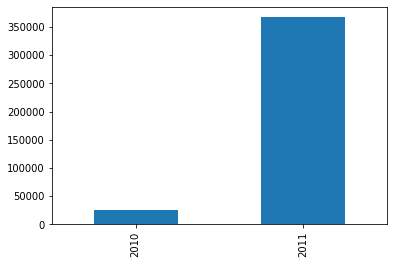

In [0]:
placed['InvoiceDate'] = pd.to_datetime(placed['InvoiceDate'], errors='coerce')
placed.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar')


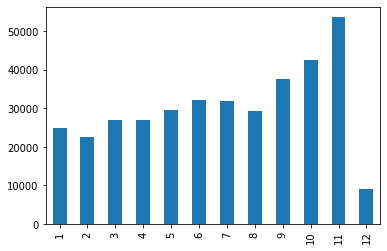

In [0]:
placed[placed.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')

# **Monthly Gross**

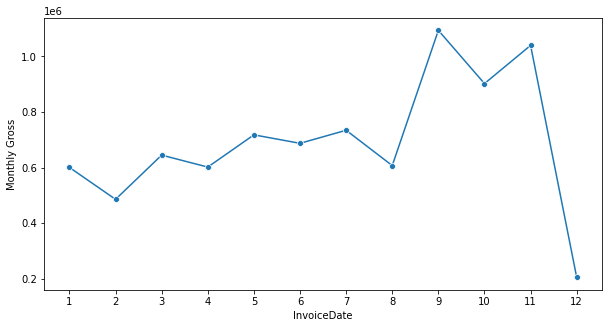

In [0]:
monthly_gross = placed[placed.InvoiceDate.dt.year==2011].groupby(placed.InvoiceDate.dt.month).TotalCost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index,marker='o')
plt.xticks(range(1,13))
plt.ylabel('Monthly Gross')
plt.show()

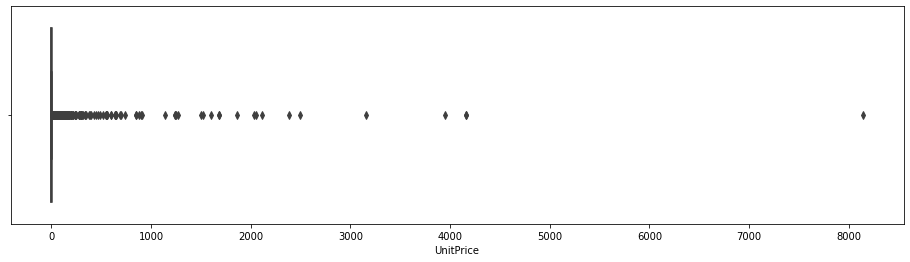

In [0]:
plt.figure(figsize=(16,4))
sns.boxplot(y='UnitPrice',data = placed,orient='h')

Unit Price is more concentrated in lower values of prices.

# **Top Selling Products**

In [0]:
placed.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34


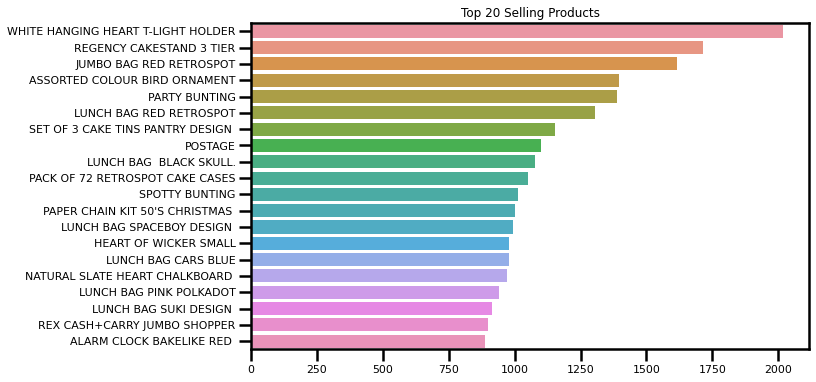

In [0]:
top_products = placed['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("poster",font_scale=0.5)
sns.barplot(y=top_products.index,x=top_products.values)
plt.title('Top 20 Selling Products')
plt.show()

# **Cohort Analysis**

In [0]:
# Create a copy of rfm_train dataframe for cohort analysis
cohort = rfm_train.copy()

cohort['InvoiceDate'] = pd.to_datetime(cohort['InvoiceDate'], errors='coerce')

# Define a function that will parse the date

import datetime as dt

def get_month(x):
    return dt.datetime(x.year,x.month,1) 

# Create InvoiceMonth column
cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month) 

# Group by CustomerID and select the InvoiceMonth value
grouping = cohort.groupby('CustomerID')['InvoiceMonth'] 

# Assign a minimum InvoiceMonth value to the dataset
cohort['CohortMonth'] = grouping.transform('min')


def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month


# Get the integers for date parts from the `InvoiceMonth` column
invoice_year, invoice_month = get_date_int(cohort,'InvoiceMonth')

# Get the integers for date parts from the `CohortMonth` column
cohort_year, cohort_month = get_date_int(cohort,'CohortMonth')

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1
cohort.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,2010-01-01,2010-01-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01-01,2010-01-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,2010-01-01,2010-01-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01-01,2010-01-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01-01,2010-01-01,1


# **Retention Rate**

In [0]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])

#No. of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')

cohort_sizes = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_sizes,axis=0)*100

#print(cohort_counts)

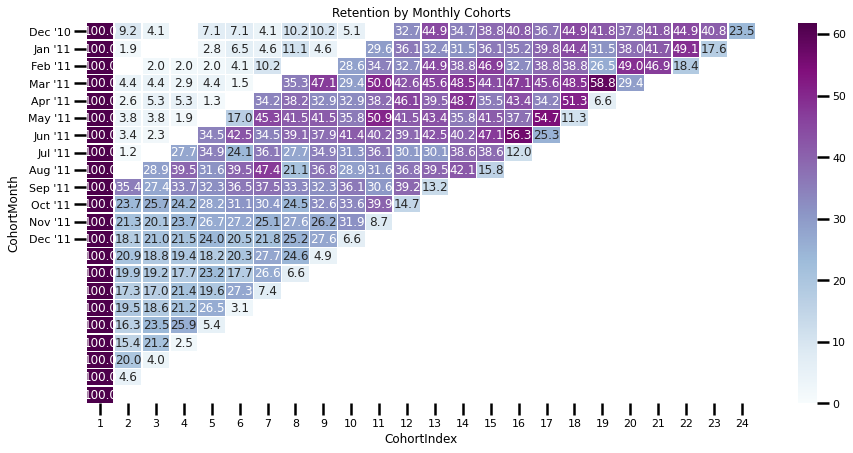

In [0]:
monthlist=["Dec '10","Jan '11","Feb '11","Mar '11","  Apr '11","May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11","Oct '11", "Nov '11", "Dec '11"]

plt.figure(figsize=(15,7))

plt.title('Retention by Monthly Cohorts')

sns.heatmap(retention,annot=True,cmap='BuPu',vmin=0.0,vmax = list(retention.max().sort_values(ascending = False))[1]+3,linewidth=0.3,fmt = '.1f',yticklabels=monthlist)

plt.show()

# **Average price per Cohort**

In [0]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['UnitPrice'].mean()
cohort_data = cohort_data.reset_index()
average_price = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='UnitPrice')
average_price.round(1)
average_price.index = average_price.index.date

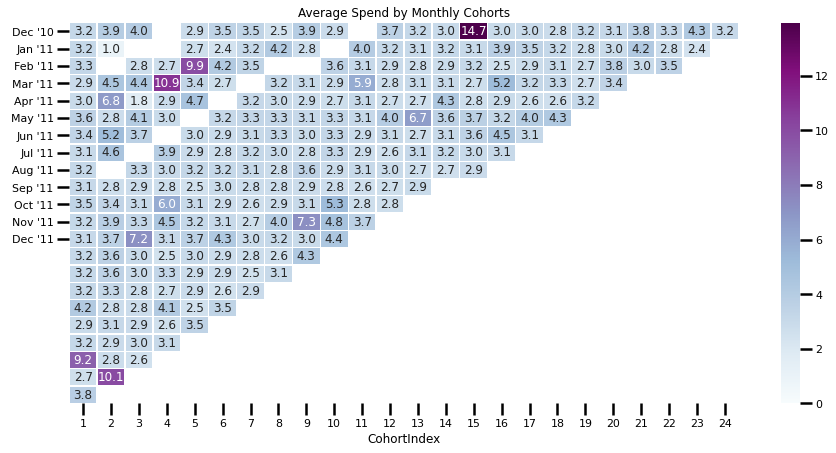

In [0]:
plt.figure(figsize=(15,7))
plt.title('Average Spend by Monthly Cohorts')
sns.heatmap(average_price,annot=True,vmin=0.0,cmap='BuPu',vmax=list(average_price.max().sort_values(ascending=False))[1]+3,fmt='.1f',linewidths=0.3,yticklabels=monthlist)
plt.show()

# **Average Quantity per Cohort**

In [0]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')


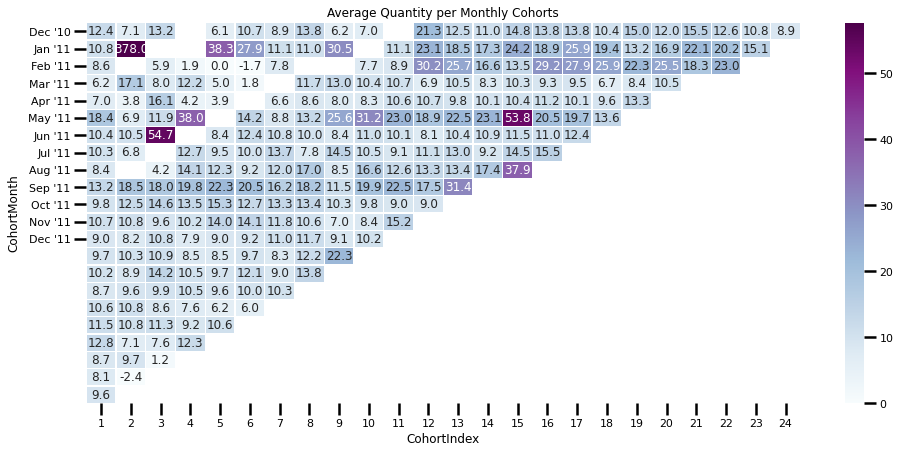

In [0]:
plt.figure(figsize=(16,7))
plt.title('Average Quantity per Monthly Cohorts')
sns.heatmap(average_quantity,vmin=0.0,vmax=list(average_quantity.max().sort_values(ascending=False))[1]+3,cmap='BuPu',linewidth=0.3,fmt='.1f',yticklabels=monthlist,annot=True)
plt.show()

# ***RFM ANALYSIS***                
![alt text](https://drive.google.com/uc?id=15SMKujEHVxb7Pi6XG_g1dOv1EFOYHtNf)

# **Recency**

In [0]:
## Lastest date in the Order History

rfm_train['InvoiceDate'].max()

'31-10-2011 17:13'

In [0]:
current_date = dt.date(2011,12,10)


In [0]:
rfm_train['InvoiceDate'] = pd.to_datetime(rfm_train['InvoiceDate'], errors='coerce')

rfm_train['Purchase_Date'] = rfm_train.InvoiceDate.dt.date

print(rfm_train['Purchase_Date'])

0         2010-01-12
1         2010-01-12
2         2010-01-12
3         2010-01-12
4         2010-01-12
             ...    
541904    2011-09-12
541905    2011-09-12
541906    2011-09-12
541907    2011-09-12
541908    2011-09-12
Name: Purchase_Date, Length: 401564, dtype: object


Create Seperate Column for Recency 

In [0]:
recency = rfm_train.groupby('CustomerID')['Purchase_Date'].max().reset_index()

In [0]:
recency = recency.assign(Current_Date=current_date)
recency['Recency'] = recency.Purchase_Date.apply(lambda x:(current_date-x).days)
recency.head()

,CustomerID,Purchase_Date,Current_Date,Recency
0,12346,2011-01-18,2011-12-10,326
1,12347,2011-10-31,2011-12-10,40
2,12348,2011-09-25,2011-12-10,76
3,12349,2011-11-21,2011-12-10,19
4,12350,2011-02-02,2011-12-10,311


In [0]:
## Drop Date Columns which is not useful anymore.

recency.drop(['Purchase_Date','Current_Date'],axis=1,inplace=True)
recency.head()

,CustomerID,Recency
0,12346,326
1,12347,40
2,12348,76
3,12349,19
4,12350,311


Create Seperate Column for Frequency

In [0]:
frequency = rfm_train.groupby('CustomerID').InvoiceNo.nunique().reset_index().rename(columns={'InvoiceNo':'Frequency'})
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


Create seperate Column for Monetary

In [0]:
rfm_train['TotalCost'] = rfm_train.Quantity*rfm_train.UnitPrice
monetary = rfm_train.groupby('CustomerID').TotalCost.sum().reset_index().rename(columns={'TotalCost':'Monetary'})
monetary.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


# **Combine Recency, Frequency and Monetary**

In [0]:
combine = recency.merge(frequency,on='CustomerID')
rfm_table = combine.merge(monetary,on='CustomerID')
rfm_table.set_index('CustomerID',inplace=True)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,2,0.00
12347,40,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40


# QQ Plot

In [0]:
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox


def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()


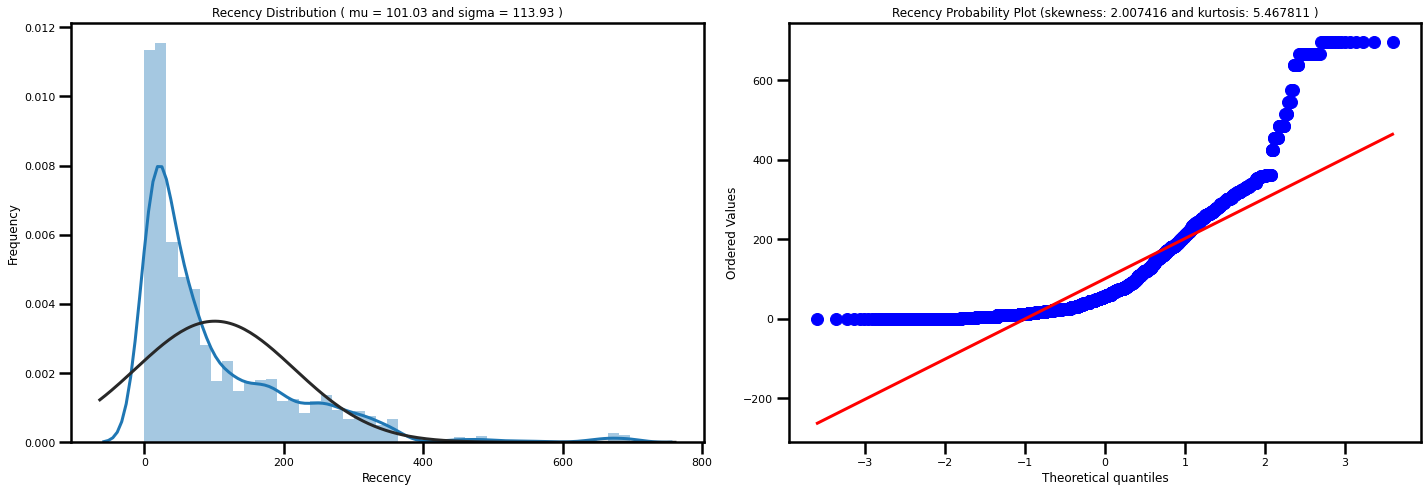

In [0]:
# Recency 
QQ_plot(rfm_table.Recency,'Recency')

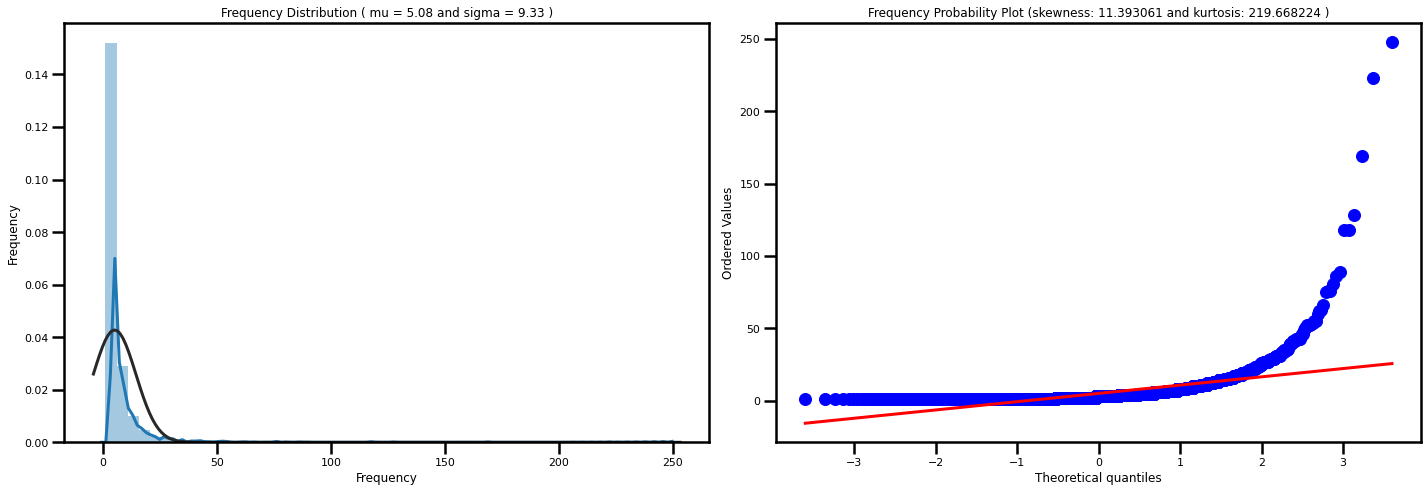

In [0]:
#Frequency 
QQ_plot(rfm_table.Frequency,'Frequency')

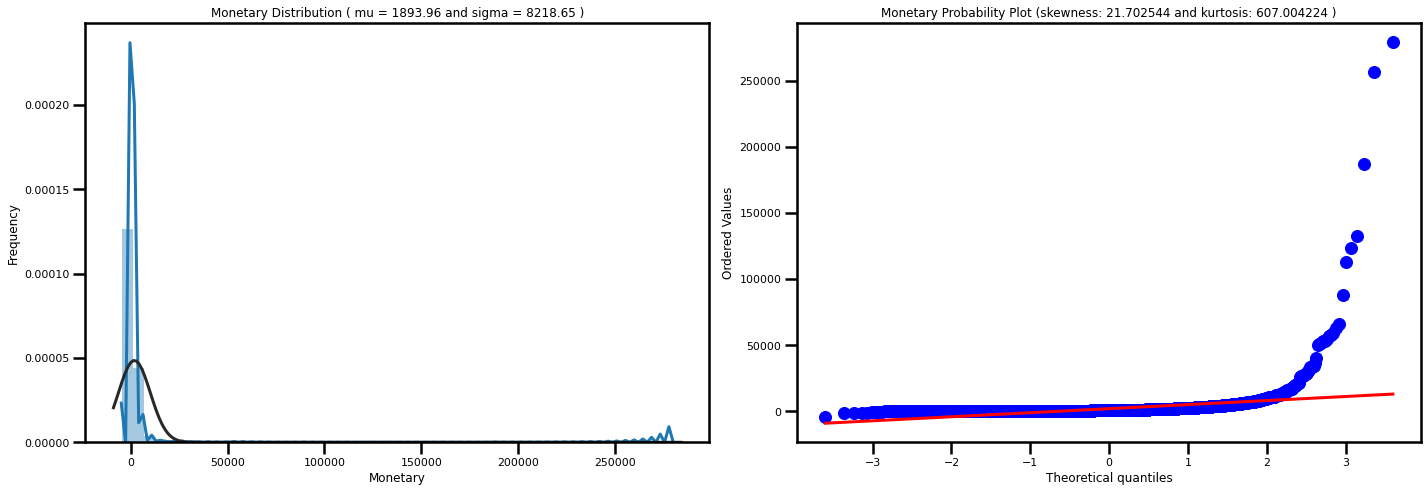

In [0]:
#Monetary 
QQ_plot(rfm_table.Monetary,'Monetary')

# **Customer Segmentation Using Quantiles**

In [0]:
quantil = rfm_table.quantile(q=[0.25,0.50,0.75])
print(quantil)

      Recency  Frequency  Monetary
0.25     20.0        1.0    291.94
0.50     57.0        3.0    644.24
0.75    152.0        5.0   1608.94


In [0]:
# Convert quantil into dict to access each value

quantil = quantil.to_dict()
print(quantil)

{'Recency': {0.25: 20.0, 0.5: 57.0, 0.75: 152.0}, 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0}, 'Monetary': {0.25: 291.94, 0.5: 644.2400000000001, 0.75: 1608.94}}


In [0]:
def RecencyPoints(y,rfm,q):
  if y<=q[rfm][0.25]:
    return 4
  elif y<=q[rfm][0.50]:
    return 3
  elif y<=q[rfm][0.75]:
    return 2
  else:
    return 1

def Freq_MonetaryPoints(y,rfm,q):
    if y <= q[rfm][0.25]:
        return 1
    elif y <= q[rfm][0.50]:
        return 2
    elif y <= q[rfm][0.75]: 
        return 3
    else:
        return 4

rfm_segment = rfm_table.copy()
rfm_segment['Recency_Quartile'] = rfm_segment['Recency'].apply(RecencyPoints,args=('Recency',quantil,))
rfm_segment['Frequency_Quartile'] = rfm_segment['Frequency'].apply(Freq_MonetaryPoints,args=('Frequency',quantil,))
rfm_segment['Monetary_Quartile'] = rfm_segment['Monetary'].apply(Freq_MonetaryPoints,args=('Monetary',quantil,))
rfm_segment.head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile
CustomerID,,,,,,
12346,326,2,0.00,1,2,1
12347,40,7,4310.00,3,4,4
12348,76,4,1797.24,2,3,4
12349,19,1,1757.55,4,1,4
12350,311,1,334.40,1,1,2


In [0]:
rfm_segment['RFMPoints'] = rfm_segment.Recency_Quartile.map(str)+rfm_segment.Frequency_Quartile.map(str)+rfm_segment.Monetary_Quartile.map(str)
print(rfm_segment['RFMPoints'])

CustomerID
12346    121
12347    344
12348    234
12349    414
12350    112
        ... 
18280    111
18281    411
18282    221
18283    444
18287    424
Name: RFMPoints, Length: 4371, dtype: object


# **RFM Classification**

In [0]:
customer_dict = {'Best Customers':'444','Loyal Customers':'344','Big Spender':'334','Almost Lost':'244','Lost Customers':'144','Recent Customers':'443','Lost Cheap Customers':'122'}


In [0]:
dict_segment = dict(zip( customer_dict.values(),customer_dict.keys()))

rfm_segment['Segment'] = rfm_segment.RFMPoints.map(lambda x:dict_segment.get(x))
rfm_segment.Segment.fillna('others',inplace = True)
rfm_segment.sample(10)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
16883,218,2,272.48,1,2,1,121,others
13784,10,11,2462.79,4,4,4,444,Best Customers
15237,79,4,1412.32,2,3,3,233,others
17414,44,2,778.00,3,2,3,323,others
12845,268,4,354.09,1,3,2,132,others
14428,47,7,1209.37,3,4,3,343,others
15840,0,3,345.66,4,2,2,422,others
16332,29,8,1572.80,3,4,3,343,others
16379,19,5,2131.90,4,3,4,434,others


In [0]:
# Best Customers who's recency, frequency as well as monetary attribute is highest.
rfm_segment[rfm_segment.RFMPoints=='444'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
14646,2,76,279489.02,4,4,4,444,Best Customers
18102,12,62,256438.49,4,4,4,444,Best Customers
17450,3,55,187322.17,4,4,4,444,Best Customers
14911,0,248,132458.73,4,4,4,444,Best Customers
14156,0,66,113214.59,4,4,4,444,Best Customers


In [0]:
# Big Spenders 
rfm_segment[rfm_segment.RFMPoints=='334'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
15749,39,4,21535.90,3,3,4,334,Big Spender
16303,26,4,5305.83,3,3,4,334,Big Spender
16258,46,5,5203.51,3,3,4,334,Big Spender
12432,43,5,5059.32,3,3,4,334,Big Spender
15786,44,5,4821.00,3,3,4,334,Big Spender


In [0]:
# Almost Lost who's recency is very low
rfm_segment[rfm_segment.RFMPoints=='244'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
16333,124,22,26626.80,2,4,4,244,Almost Lost
17735,109,19,13110.02,2,4,4,244,Almost Lost
12409,65,7,11056.93,2,4,4,244,Almost Lost
17581,66,31,10716.31,2,4,4,244,Almost Lost
14769,78,10,10383.83,2,4,4,244,Almost Lost


In [0]:
 #Lost customers that don't need attention who's recency, frequency as well as monetary values are low
rfm_segment[rfm_segment.RFMPoints=='122'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
13417,206,2,640.83,1,2,2,122,Lost Cheap Customers
14481,165,2,636.51,1,2,2,122,Lost Cheap Customers
15384,170,3,635.76,1,2,2,122,Lost Cheap Customers
14220,189,2,632.40,1,2,2,122,Lost Cheap Customers
15244,214,2,631.57,1,2,2,122,Lost Cheap Customers


In [0]:
# loyal customers who's purchase frequency is high
rfm_segment[rfm_segment.RFMPoints=='344'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
12415,25,26,123725.45,3,4,4,344,Loyal Customers
13694,26,60,62690.54,3,4,4,344,Loyal Customers
16029,30,76,53168.69,3,4,4,344,Loyal Customers
15769,41,29,51823.72,3,4,4,344,Loyal Customers
14298,53,45,50862.44,3,4,4,344,Loyal Customers


In [0]:
#customers that you must retain are those whose monetary and frequency was high but recency reduced quite a lot recently
rfm_segment[rfm_segment.RFMPoints=='244'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
16333,124,22,26626.80,2,4,4,244,Almost Lost
17735,109,19,13110.02,2,4,4,244,Almost Lost
12409,65,7,11056.93,2,4,4,244,Almost Lost
17581,66,31,10716.31,2,4,4,244,Almost Lost
14769,78,10,10383.83,2,4,4,244,Almost Lost


# **K-Means Clustering**

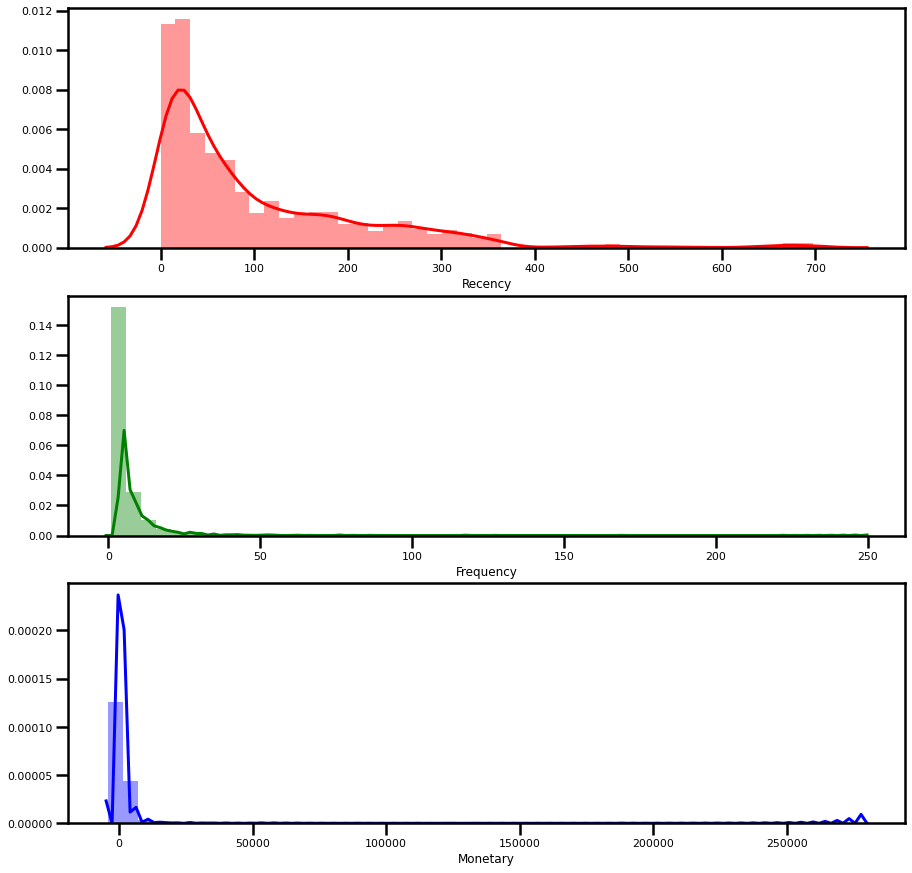

In [0]:
fig,axes = plt.subplots(3,1,figsize=(15,15))
sns.distplot(rfm_table.Recency,color='Red',axlabel='Recency',ax=axes[0])
sns.distplot(rfm_table.Frequency,color='Green',axlabel='Frequency',ax=axes[1])
sns.distplot(rfm_table.Monetary,color='Blue',axlabel='Monetary',ax=axes[2])
plt.show()

In [0]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4371.000000,4371.000000,4371.000000
mean,101.026996,5.075726,1893.964636
std,113.939264,9.332529,8219.586584
min,0.000000,1.000000,-4287.630000
25%,20.000000,1.000000,291.940000
50%,57.000000,3.000000,644.240000
75%,152.000000,5.000000,1608.940000
max,697.000000,248.000000,279489.020000


In [0]:
scaled_rfm = rfm_table.copy()
scaled_rfm.Monetary = rfm_table.Monetary + abs(rfm_table.Monetary.min())+1
scaled_rfm.Recency = rfm_table.Recency + abs(rfm_table.Recency.min())+1
scaled_rfm.describe()

,Recency,Frequency,Monetary
count,4371.000000,4371.000000,4371.000000
mean,102.026996,5.075726,6182.594636
std,113.939264,9.332529,8219.586584
min,1.000000,1.000000,1.000000
25%,21.000000,1.000000,4580.570000
50%,58.000000,3.000000,4932.870000
75%,153.000000,5.000000,5897.570000
max,698.000000,248.000000,283777.650000


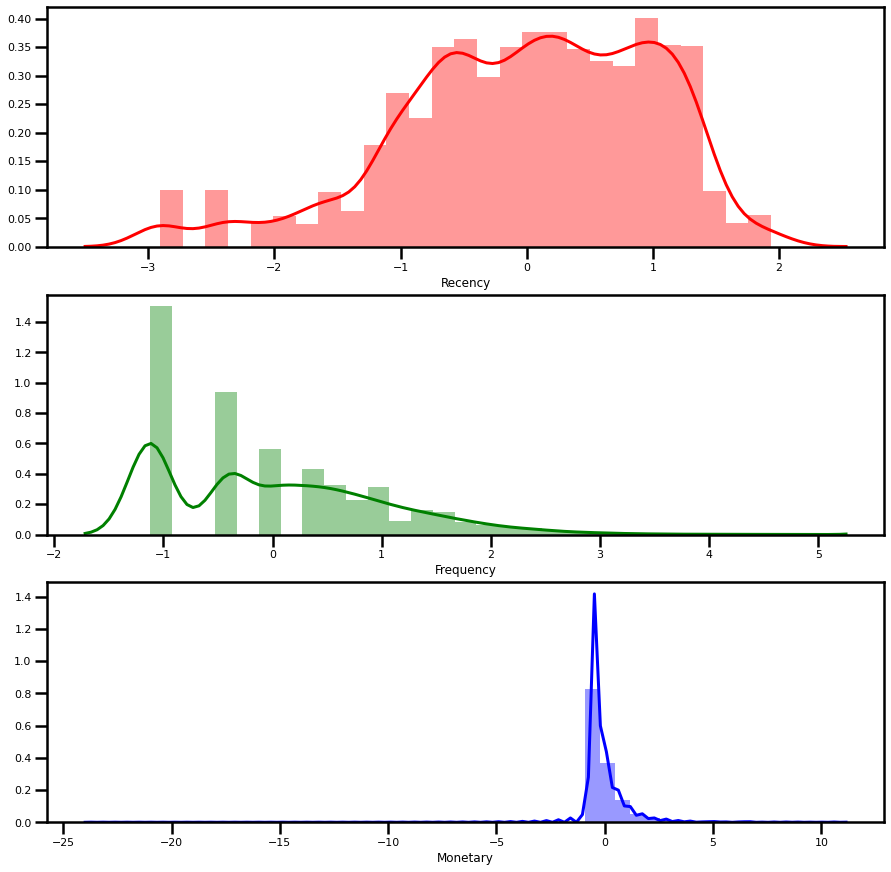

In [0]:
import numpy as np

from sklearn.preprocessing import StandardScaler

log_df = np.log(scaled_rfm)
scal = StandardScaler()
normal_ = scal.fit_transform(log_df)
normal_ = pd.DataFrame(data=normal_,index = rfm_table.index,columns=rfm_table.columns)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(normal_.Recency , color="Red", ax=axes[0], axlabel='Recency')
sns.distplot(normal_.Frequency , color="Green", ax=axes[1], axlabel='Frequency')
sns.distplot(normal_.Monetary , color="Blue", ax=axes[2], axlabel='Monetary')
plt.show()

# **Silhouette Method for Finding Optimal K-value**

Silhouette score for number of cluster(s) 2: 0.43807530194052363
Silhouette score for number of cluster(s) 3: 0.3991753861582
Silhouette score for number of cluster(s) 4: 0.3500619849787263
Silhouette score for number of cluster(s) 5: 0.36210090709282666
Silhouette score for number of cluster(s) 6: 0.3636105605959766
Silhouette score for number of cluster(s) 7: 0.3486400691694118
Silhouette score for number of cluster(s) 8: 0.34868006980676636
Silhouette score for number of cluster(s) 9: 0.3522117762597429
Silhouette score for number of cluster(s) 10: 0.3502864119669303
Silhouette score for number of cluster(s) 11: 0.3481367794610651


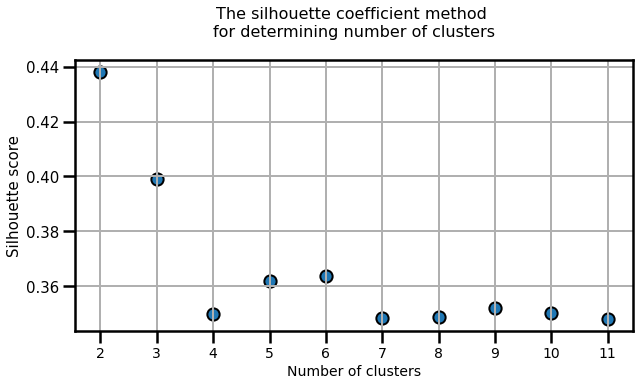

In [0]:
 from sklearn.metrics import silhouette_score
 from sklearn.cluster import KMeans
wcss_silhouette = []
for i in range(2,12):
    kmean = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(normal_)
    predss = kmean.predict(normal_)    
    silhouette = silhouette_score(normal_,predss)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=wcss_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

# **Optimal Value for K is 4**

In [0]:
kme = KMeans(n_clusters=4, random_state=1, init='k-means++')
kme.fit(normal_)
cluster_labels = kme.labels_
print(f"Shape of cluster label array is {cluster_labels.shape}")
print(f"Shape of RFM segment dataframe is {rfm_segment.shape}")
Cluster_table = rfm_segment.assign(Cluster = cluster_labels)

# Check counts of records assigned to different clusters
Cluster_table.Cluster.value_counts()

Shape of cluster label array is (4371,)
Shape of RFM segment dataframe is (4371, 8)


1    1795
2    1640
0     839
3      97
Name: Cluster, dtype: int64

In [0]:
Cluster_table.sample(10)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
12620,15,3,1339.41,4,2,3,423,others,2
13678,33,1,232.60,3,1,1,311,others,1
15806,47,3,784.58,3,2,3,323,others,2
16217,128,4,259.39,2,3,1,231,others,2
14109,24,2,80.20,3,2,1,321,others,2
13389,12,3,797.96,4,2,3,423,others,2
16320,66,2,1038.46,2,2,3,223,others,2
16169,40,4,1822.97,3,3,4,334,Big Spender,2
13270,485,1,590.00,1,1,2,112,others,1


In [0]:
Cluster_table[Cluster_table.Cluster == 3].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
13199,11,39,9803.96,4,4,4,444,Best Customers,3
12731,24,14,18793.41,3,4,4,344,Loyal Customers,3
12971,9,89,10930.26,4,4,4,444,Best Customers,3
12678,43,13,17588.26,3,4,4,344,Loyal Customers,3
15838,12,21,33350.76,4,4,4,444,Best Customers,3


In [0]:
Cluster_table[Cluster_table.Cluster == 2].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
15407,95,4,1046.74,2,3,3,233,others,2
15680,10,3,1333.68,4,2,3,423,others,2
12982,36,2,377.20,3,2,2,322,others,2
18059,10,4,296.71,4,3,2,432,others,2
16225,45,5,1096.32,3,3,3,333,others,2


In [0]:
Cluster_table[Cluster_table.Cluster == 1].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
16108,85,2,816.10,2,2,3,223,others,1
12769,239,1,1143.60,1,1,3,113,others,1
15512,156,2,121.00,1,2,1,121,others,1
15017,182,1,125.58,1,1,1,111,others,1
16569,181,1,124.20,1,1,1,111,others,1


In [0]:
Cluster_table[Cluster_table.Cluster == 0].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
14744,17,9,1088.53,4,4,3,443,Recent Customers,0
12380,22,5,2720.56,3,3,4,334,Big Spender,0
17193,0,9,1674.46,4,4,4,444,Best Customers,0
12557,17,5,11990.96,4,3,4,434,others,0
15971,1,12,4199.85,4,4,4,444,Best Customers,0


# **Clusters in Scatter Plot**

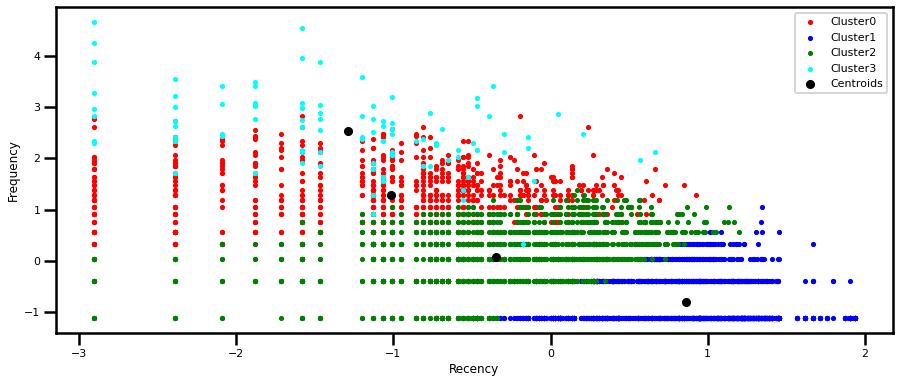

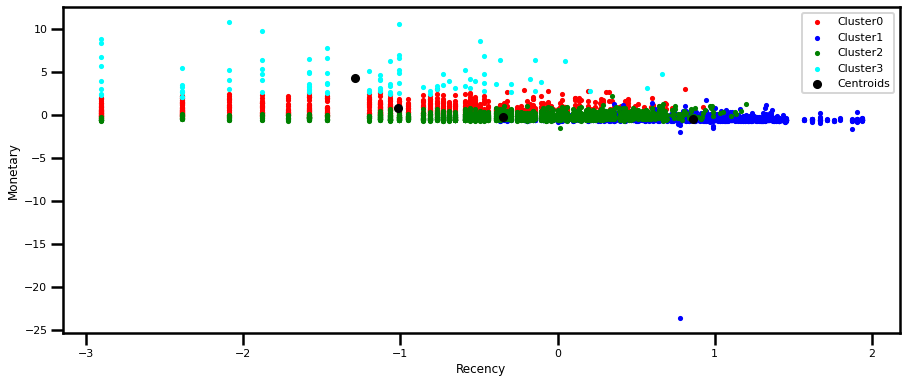

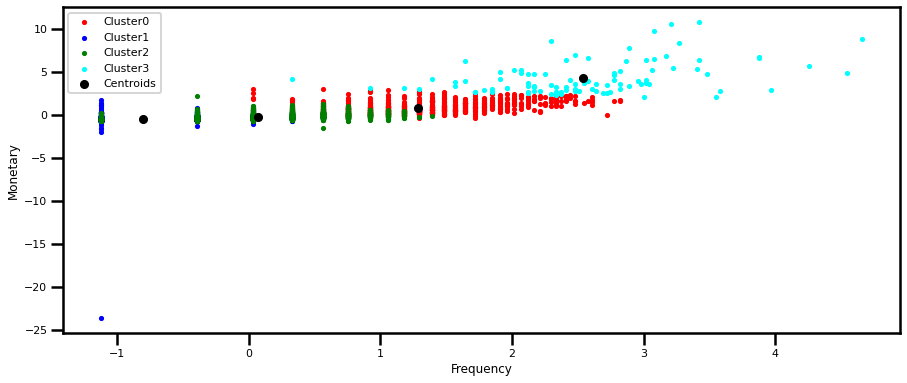

In [0]:
# Plotting two dimesional plots of each attributes respectively.
Y = normal_.iloc[:,0:3].values
count=Y.shape[1]
for i in range(0,count):
    for j in range(i+1,count):
        plt.figure(figsize=(15,6));
        plt.scatter(Y[cluster_labels == 0, i], Y[cluster_labels == 0, j], s = 10, c = 'red', label = 'Cluster0')
        plt.scatter(Y[cluster_labels == 1, i], Y[cluster_labels == 1, j], s = 10, c = 'blue', label = 'Cluster1')
        plt.scatter(Y[cluster_labels == 2, i], Y[cluster_labels == 2, j], s = 10, c = 'green', label = 'Cluster2')
        plt.scatter(Y[cluster_labels == 3, i], Y[cluster_labels == 3, j], s = 10, c = 'cyan', label = 'Cluster3')
        plt.scatter(kme.cluster_centers_[:,i], kme.cluster_centers_[:,j], s = 50, c = 'black', label = 'Centroids')
        plt.xlabel(normal_.columns[i])
        plt.ylabel(normal_.columns[j])
        plt.legend()        
        plt.show();

# **Snake Plot**

# Melt in Pandas

In [0]:
# Assign Cluster values to each customer in normalized dataframe
normal_ = normal_.assign(Cluster = cluster_labels)

# Melt normalized dataframe into long form to have all metric in same column
normal_melt = pd.melt(normal_.reset_index(),
                      id_vars=['CustomerID','Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric',
                      value_name='Value')
normal_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346,1,Recency,1.375630
1,12347,0,Recency,-0.159779
2,12348,2,Recency,0.306254
3,12349,2,Recency,-0.690594
4,12350,1,Recency,1.340907


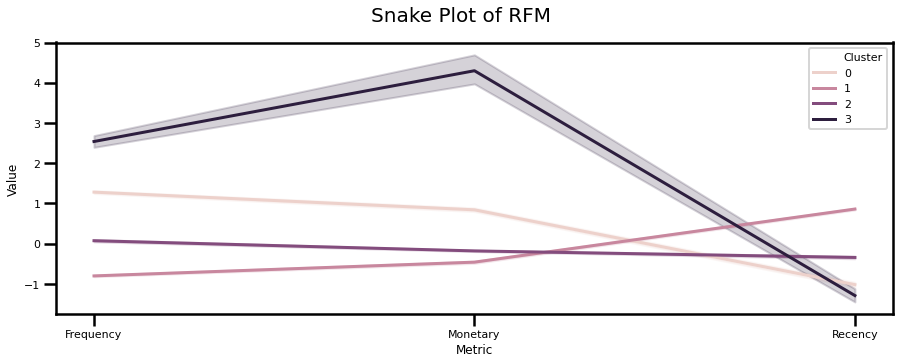

In [0]:
plt.figure(figsize=(15,5))
sns.lineplot(x = 'Metric',y = 'Value',hue = 'Cluster',data = normal_melt)
plt.suptitle("Snake Plot of RFM",fontsize=20)
plt.show()

## **Association Mining**

# Create Transaction Level Dataframe

In [0]:
items = list(rfm_train.Description.unique())
grouped = rfm_train.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
# A Transaction dataframe with items as columns with binary values is created
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

print(transaction_df)

       WHITE HANGING HEART T-LIGHT HOLDER  ...  PAPER CRAFT , LITTLE BIRDIE
0                                       1  ...                            0
1                                       0  ...                            0
2                                       0  ...                            0
3                                       0  ...                            0
4                                       0  ...                            0
...                                   ...  ...                          ...
22181                                   0  ...                            1
22182                                   0  ...                            0
22183                                   0  ...                            0
22184                                   0  ...                            0
22185                                   0  ...                            0

[22186 rows x 3896 columns]


# Pruning the Dataset for frequently purchased items

In [0]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    
    total_items = sum(input_df.sum().sort_values(ascending = False))
    #print(total_items)
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]



Adding an additional column denoting the total amount in a purchase

In [0]:
rfm_train['Amount'] = rfm_train.Quantity*rfm_train.UnitPrice

In [0]:
AmoutSum = rfm_train.groupby(["Description"]).Amount.sum().sort_values(ascending = False)
inv = rfm_train[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
 agg(np.size).sort_values(ascending = False)
Top10Ev = list(inv[:10].index)
Top15ev = list(inv[:15].index)


Pruning based on Rank of items

In [0]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print(output_df)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])



       WHITE HANGING HEART T-LIGHT HOLDER  ...  NATURAL SLATE HEART CHALKBOARD 
13                                      0  ...                                0
23                                      1  ...                                0
27                                      0  ...                                0
33                                      1  ...                                0
36                                      0  ...                                0
...                                   ...  ...                              ...
21809                                   1  ...                                0
21938                                   0  ...                                0
21983                                   0  ...                                0
21995                                   0  ...                                0
22069                                   0  ...                                0

[4724 rows x 15 columns]
Total of Sales

# Importing Necessary Libraries for Association Rule Mining

In [0]:
!pip install orange3

     |████████████████████████████████| 2.5MB 2.9MB/s 
     |████████████████████████████████| 143kB 53.5MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 225kB 56.0MB/s 
     |████████████████████████████████| 1.6MB 49.5MB/s 
     |████████████████████████████████| 1.5MB 48.5MB/s 
     |████████████████████████████████| 450kB 55.4MB/s 
     |████████████████████████████████| 1.1MB 46.9MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 2.7MB 31.1MB/s 
  Created wheel for pyqtgraph: filename=pyqtgraph-0.10.0-cp36-none-any.whl size=735678 sha256=6b4a9b063d323ea3b0dcc29002507c1d9d9e7007f854a08908cd436c81155ca1
  Stored in directory: /root/.cache/pip/wheels/93/a2/de/184ecdefdb91d760706d02389015dfa3b96e927eb1c42ace37
  Created wheel for serverfiles: filename=serverfiles-0.3.0-cp36-none-any.whl size=6885 sha256=1580657b6e0c94f2f71df2f4c7e96ea6f0fdb849e0694ae4361bfe47deeeaa1e
  Stored in directo

In [0]:
!pip3 install Orange3-Associate

     |████████████████████████████████| 532kB 2.8MB/s 
  Created wheel for Orange3-Associate: filename=Orange3_Associate-1.1.5-cp36-cp36m-linux_x86_64.whl size=186227 sha256=c062e512cfff3f10e601ab044f4f26c1468ede3063e6fdc0c31d2ae2ebec9128
  Stored in directory: /root/.cache/pip/wheels/80/61/4a/dcd517a56d437ea374e32f2c7ffdb31047edab82d82d665af5
Successfully built Orange3-Associate


In [0]:
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from sklearn import preprocessing
from orangecontrib.associate.fpgrowth import *


# Creating Orange Table Data Structure

In [0]:
input_assoc_rules = output_df
print(output_df)
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])


# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules.values,Y= None)

print(data_tran[0:7])

# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)
print(data_tran_en)
print(sorted(mapping.items()))

       WHITE HANGING HEART T-LIGHT HOLDER  ...  NATURAL SLATE HEART CHALKBOARD 
13                                      0  ...                                0
23                                      1  ...                                0
27                                      0  ...                                0
33                                      1  ...                                0
36                                      0  ...                                0
...                                   ...  ...                              ...
21809                                   1  ...                                0
21938                                   0  ...                                0
21983                                   0  ...                                0
21995                                   0  ...                                0
22069                                   0  ...                                0

[4724 rows x 15 columns]
[[0, 0, 0, 0, 

In [0]:
support = 0.01
# Number of minimum transactions for each rule
print("Number  of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

Number  of required transactions =  47
Items Set Size: 661418


### **Generating Rules using FP Growth Algorithm**

In [0]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]     
        cons = ex_rule_frm_rule_stat[1]

        named_cons = names[next(iter(cons))]
       
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
   
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if  rules_df.empty:
        print("No rule generated")
    pd.options.display.max_colwidth = 10  
    print(rules_df.head())

Raw rules data frame of 13275 rules generated
   support  confidence  coverage  ...  leverage  antecedent  consequent
0       48   0.615385   0.016511  ...  0.005991  LUNCH ...   LUNCH ... 
1       48   0.640000   0.015876  ...  0.007022  LUNCH ...   LUNCH ... 
2       48   0.607595   0.016723  ...  0.007028  LUNCH ...   LUNCH ... 
3       62   0.666667   0.019687  ...  0.008153  LUNCH ...   LUNCH ... 
4       62   0.639175   0.020533  ...  0.009065  LUNCH ...   LUNCH ... 

[5 rows x 8 columns]


# First 5 rules with Highest Confidence

In [0]:
#Storing the value of default column width in a temporary variable default_width
default_width = pd.options.display.max_colwidth

pd.options.display.max_colwidth = 200


print((rules_df[['consequent','antecedent', 'support','confidence','lift']].
 sort_values(['confidence','support','lift'],ascending=False)))


                    consequent  ...      lift
2210   LUNCH BAG RED RETROSPOT  ...  3.239808
4621   LUNCH BAG RED RETROSPOT  ...  3.239808
4943   LUNCH BAG RED RETROSPOT  ...  3.224380
4659   LUNCH BAG RED RETROSPOT  ...  3.220609
7632   LUNCH BAG RED RETROSPOT  ...  3.220609
...                        ...  ...       ...
12658  LUNCH BAG RED RETROSPOT  ...  2.375859
12685  LUNCH BAG RED RETROSPOT  ...  2.375859
13113  LUNCH BAG RED RETROSPOT  ...  2.375859
13175  LUNCH BAG RED RETROSPOT  ...  2.375859
13246  LUNCH BAG RED RETROSPOT  ...  2.375859

[13275 rows x 5 columns]


# First 5 rules with Highest Support

In [0]:
pd.options.display.max_colwidth = 10

print((rules_df[['consequent', 'antecedent', 'support','confidence','lift']].
 groupby(['consequent', 'antecedent']).first().reset_index().sort_values(['support', 'confidence', 'lift'],ascending=False)).head())

   consequent antecedent  support  confidence      lift
36  LUNCH ...  LUNCH ...      200   0.607903   2.407152
37  LUNCH ...  LUNCH ...      198   0.600000   2.375859
39  LUNCH ...  LUNCH ...      153   0.602362   2.385213
25  LUNCH ...  LUNCH ...      137   0.661836   2.620714
31  LUNCH ...  LUNCH ...      134   0.606335   2.400944


Checking for rules with lift > 1

In [0]:
print(rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts())

Greater Than One    13275
Name: lift, dtype: int64


Setting maximum column width to the initial default value 

In [0]:
pd.options.display.max_colwidth = default_width